In [1]:
import math
import pandas as pd
import numpy as np
import geopandas
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pycountry
import matplotlib.patches as mpatches
import matplotlib.colors
import dataframe_image as dfi
%matplotlib inline


In [2]:
country_data = [[country.name, country.alpha_2, country.alpha_3] for country in pycountry.countries]
pycountry_df = pd.DataFrame(country_data, columns=['name', 'alpha_2', 'alpha_3'])

gpdf = geopandas.read_file("../data/shapefiles/europeborder/Europe_borders.shp")

df = pd.read_csv("../data/datasets/happines_2019.csv")[['Country or region', 'Score']]

In [3]:
df.at[(df[df['Country or region'] == 'Russia'].index[0]), 'Country or region'] = 'Russian Federation'
df.at[(df[df['Country or region'] == 'Moldova'].index[0]), 'Country or region'] = 'Moldova, Republic of'
df.at[(df[df['Country or region'] == 'Czech Republic'].index[0]), 'Country or region'] = 'Czechia'

df = df.merge(pycountry_df, how='inner', left_on='Country or region', right_on='name').drop(columns=['alpha_2', 'name']).rename(columns={'alpha_3':'iso3'})

not_in_europe = ['AZE','GEO','ARM'] 
df = df[~df['iso3'].isin(not_in_europe)]

df.sort_values("Score", ascending=False).head()

,Country or region,Score,iso3
0,Finland,7.769,FIN
1,Denmark,7.600,DNK
2,Norway,7.554,NOR
3,Iceland,7.494,ISL
4,Netherlands,7.488,NLD


In [4]:
gpdf.at[(gpdf[gpdf['NAME'] == 'Russia'].index[0]), 'NAME'] = 'Russian Federation'
gpdf.at[(gpdf[gpdf['NAME'] == 'Bosnia Herzegovina'].index[0]), 'NAME'] = 'Bosnia and Herzegovina'
gpdf.at[(gpdf[gpdf['NAME'] == 'Czech Republic'].index[0]), 'NAME'] = 'Czechia'
gpdf.at[(gpdf[gpdf['NAME'] == 'Macedonia'].index[0]), 'NAME'] = 'North Macedonia'
gpdf.at[(gpdf[gpdf['NAME'] == 'Moldova'].index[0]), 'NAME'] = 'Moldova, Republic of'
		
gpdf = gpdf.merge(pycountry_df, how='inner', left_on='NAME', right_on='name').drop(columns=['alpha_2', 'name']).rename(columns={'alpha_3':'iso3'})

gpdf.head()

,NAME,ORGN_NAME,geometry,iso3
0,Albania,Shqipëria,"MULTIPOLYGON (((19.50115 40.96230, 19.50563 40...",ALB
1,Andorra,Andorra,"POLYGON ((1.43992 42.60649, 1.45041 42.60596, ...",AND
2,Austria,Österreich,"POLYGON ((16.00000 48.77775, 16.00000 48.78252...",AUT
3,Belgium,België / Belgique,"POLYGON ((5.00000 49.79374, 4.99724 49.79696, ...",BEL
4,Bosnia and Herzegovina,Bosna i Hercegovina,"POLYGON ((19.22947 43.53458, 19.22925 43.53597...",BIH


In [5]:
merged_df = gpdf.merge(df, how="left", on='iso3')
merged_df = merged_df.to_crs(epsg=3035)

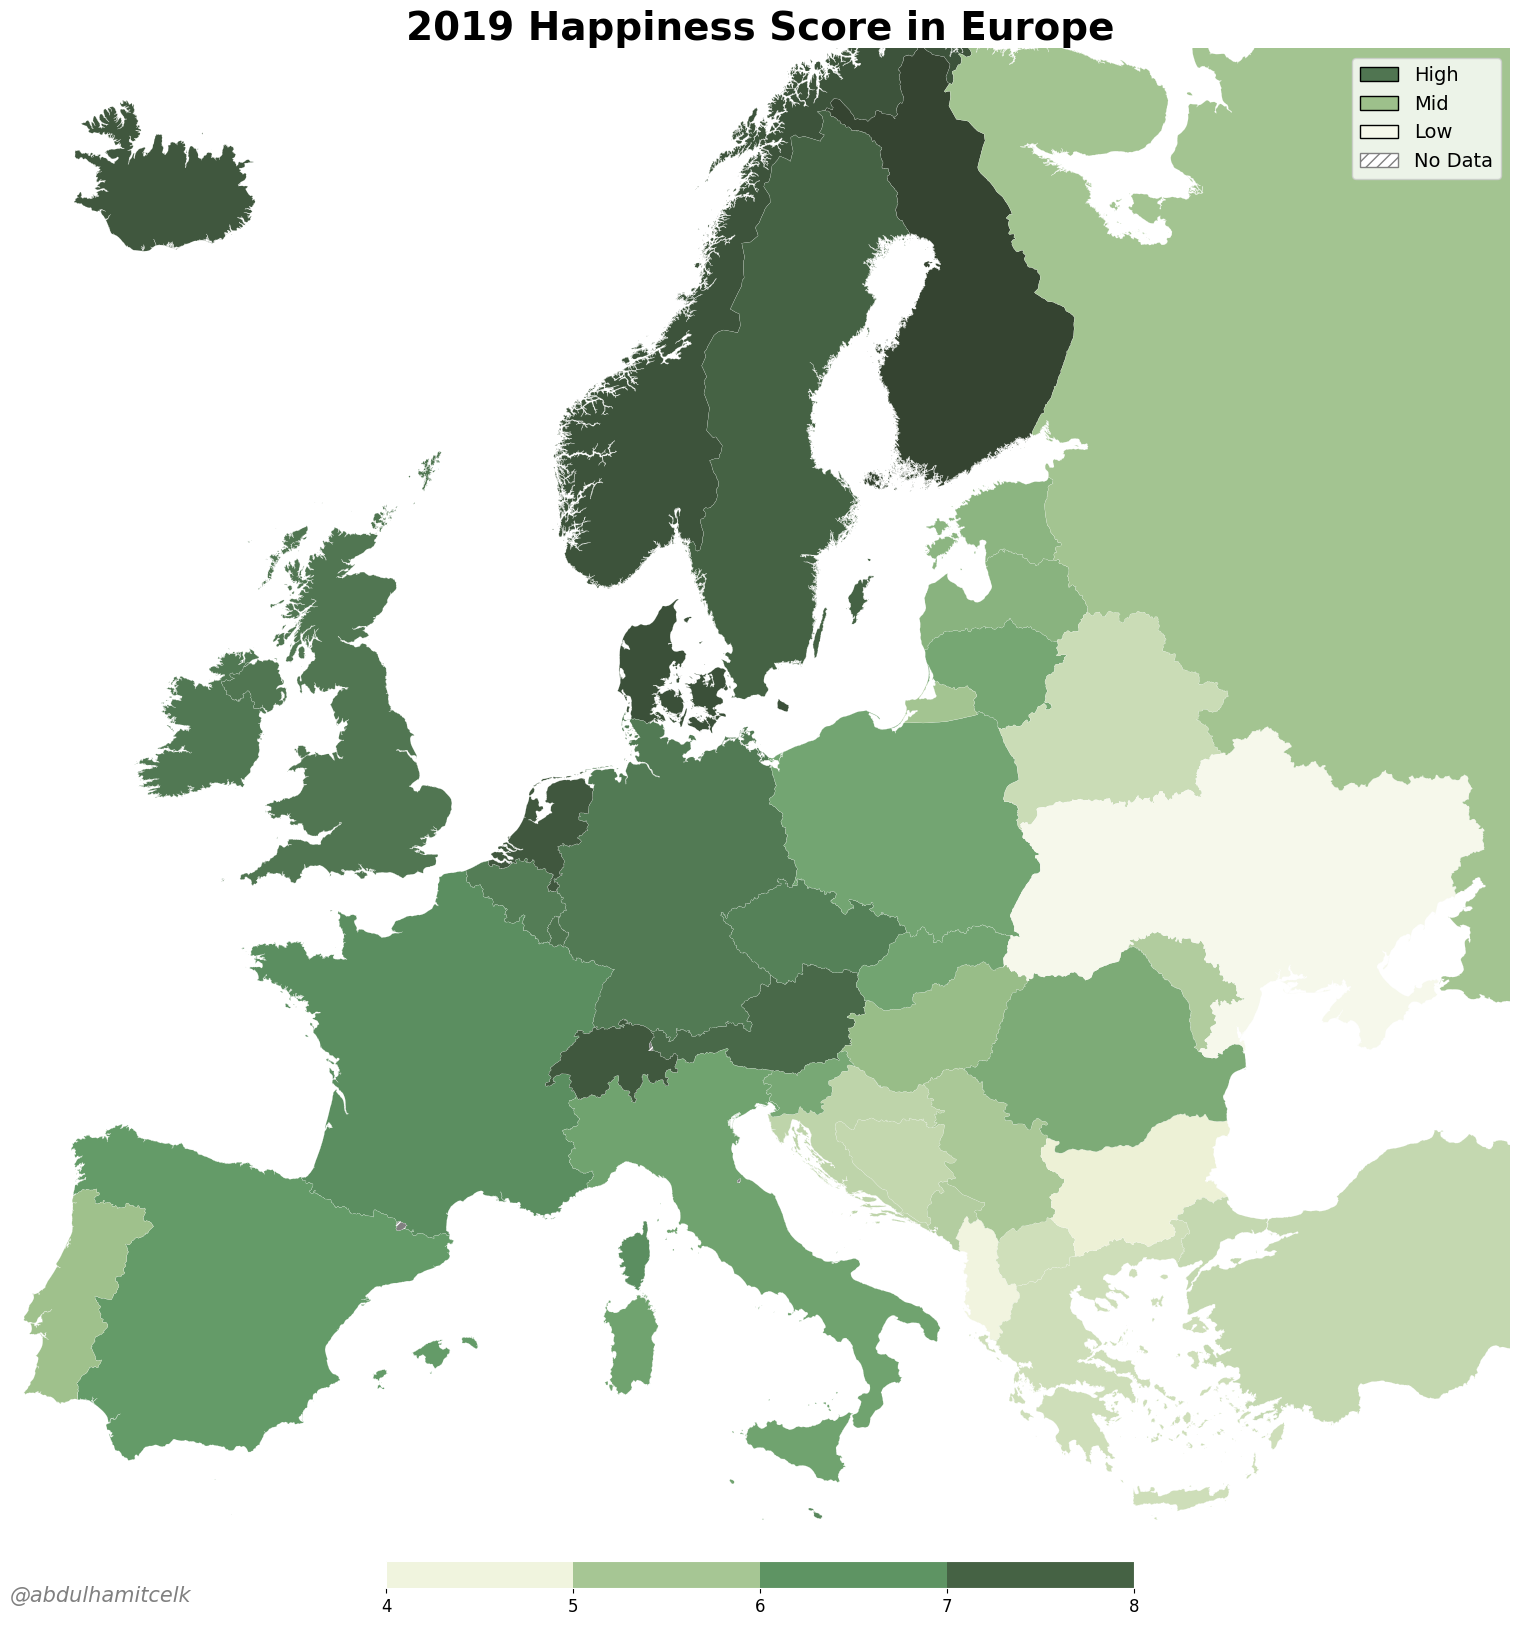

In [6]:
vmin = math.floor(merged_df['Score'].min())
vmax = round(merged_df['Score'].max())
bg_color = "white"
border_color = "white"
legend_boundaries = [i for i in range(vmin, vmax+1)]
cmap_colors = ['#F6F8EB', '#EDF1D6','#9DC08B','#609966','#507551', '#354431'] # low to high
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", cmap_colors)

fig, ax = plt.subplots(1, 1, figsize=(25,20))

merged_df.plot(
    column='Score',
    ax=ax,
    edgecolor=border_color,
    cmap=cmap,
    missing_kwds={
        "color": 'gray',
        "hatch": "///",
        "label": "Missing values",
    },
    linewidth=0.1
)

ax.set_title('2019 Happiness Score in Europe',
              fontdict={'fontsize': '28', 'fontweight': 'bold'})

scale_value = 1000000

y_lim_start = 1.4 * scale_value
y_lim_end = 5.3 * scale_value
ax.set_ylim(y_lim_start, y_lim_end)

x_lim_start = 2.6 * scale_value
x_lim_end = 6.55 * scale_value
ax.set_xlim(x_lim_start, x_lim_end)

ax.set_axis_off()

# scale map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.018, aspect=27, pad=0.02, orientation="horizontal", location="bottom", boundaries=legend_boundaries, ax=ax)
cbar.outline.set_edgecolor('white')
for t in cbar.ax.get_xticklabels():
    t.set_fontsize(12)

# bg color
fig.set_facecolor(bg_color)

# custom legend
none_color = mpatches.Patch(edgecolor='gray', facecolor='white', hatch='///', label='No Data')
high_color = mpatches.Patch(edgecolor='#000000', facecolor=cmap_colors[4],label='High')
mid_color = mpatches.Patch(edgecolor='#000000', facecolor=cmap_colors[2],label='Mid')
low_color = mpatches.Patch(edgecolor='#000000', facecolor=cmap_colors[0],label='Low')
plt.legend(handles=[high_color,mid_color,low_color,none_color], prop={'size': 14})


# signature
xtext = 2.6 * scale_value
ytext = 1.21 * scale_value
plt.text(xtext, ytext, "@abdulhamitcelk", fontstyle='italic', fontsize='15', color='#808080')

plt.savefig("europehappines2019.png", facecolor=fig.get_facecolor(), bbox_inches='tight')


In [7]:
top10_df = merged_df[['NAME','Score']].sort_values('Score', ascending=False).reset_index(drop=True).head(10)

top10_df = top10_df.reset_index().rename(columns={'NAME':'country', 'index':'rank'})
top10_df['rank'] = top10_df['rank'] + 1
top10_df['Score'] = top10_df['Score'].round(3).apply(lambda x: '{:,.3f}'.format(x))


top10_df.style.hide(axis="index")

rank,country,Score
1,Finland,7.769
2,Denmark,7.600
3,Norway,7.554
4,Iceland,7.494
5,Netherlands,7.488
6,Switzerland,7.480
7,Sweden,7.343
8,Austria,7.246
9,Luxembourg,7.090
10,United Kingdom,7.054
